# Fuzzy Systems Project



Authors:
- Matteo Caviglia - ID: 513026
- Marco Bares - ID: 513283

## Project Outline

[**Section 0**](#task0): Imports

[**Section 1**](#task1): AlphaFuzzySet Definition

[**Section 2**](#task2): AlphaFuzzySet Testing

[**Section 3**](#task3): AlphaFuzzyCombination Definition

[**Section 4**](#task4): Various Combinations display

[**Section 5**](#task5): Further

<a name='task0'></a>
## 0. Imports

In [ ]:
!pip install softpy

  Preparing metadata (setup.py) ... done
  Created wheel for softpy: filename=softpy-0.0.5-py3-none-any.whl size=18565 sha256=7b9e666252ec76e9a8cc3c3217e9bf9d234f9b8241985574e3ba4d96f22e6144
  Stored in directory: /root/.cache/pip/wheels/fb/a9/42/31bc4cd4d93817e158d879bf5e7dc7f50610f178e30a6e1717
Successfully built softpy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#sys.path.append("../source/")
from softpy.fuzzy.fuzzyset import *
from softpy.fuzzy.operations import *

<a name='task1'></a>
## 1. AlphaFuzzySet Definition

In [ ]:
class AlphaFuzzySet(ContinuousFuzzySet):
    def __init__(self, collection: dict, cont_set: ContinuousFuzzySet = None, step = 0.02):
        """
        Initialize an AlphaFuzzySet instance.

        Args:
            collection (dict): A dictionary where keys are alpha levels (0 to 1) and values are lists of intervals.
            cont_set (ContinuousFuzzySet, optional): A continuous fuzzy set to be converted to an alpha-level set.
            step (float, optional): The step size for generating alpha levels.
        """
        self.step = step
        if not collection and isinstance(cont_set, ContinuousFuzzySet):
            collection = self._convert_from_continuous(cont_set)
        self._validate_collection(collection)
        self.collection = self._initialize_collection(collection)
        self.max, self.min = self._calculate_max_min()

    def _convert_from_continuous(self, cont_set):
        """
        Convert a continuous fuzzy set into an alpha-level set.

        Args:
            cont_set (ContinuousFuzzySet): The continuous fuzzy set to convert.

        Returns:
            dict: A dictionary with alpha levels as keys and intervals as values.
        """
        collection = {}
        for alpha in np.arange(0, 1.0 + self.step, self.step):
            if alpha > 1:
                alpha = 1
            alpha = round(alpha, 2)
            acut = alpha_cut(cont_set, alpha, np.arange(cont_set.min, cont_set.max, 0.005))
            collection[alpha] = [[round(interval[0], 2), round(interval[1], 2)] for interval in acut]
        return collection

    def _initialize_collection(self, collection):
        """
        Initialize the collection with the required format and handle alpha level 0.

        Args:
            collection (dict): The initial collection of alpha levels and intervals.

        Returns:
            dict: The formatted collection.
        """
        collection[0] = [[-np.inf, np.inf]]
        return self._format_collection(collection)

    def _calculate_max_min(self):
        """
        Calculate the maximum and minimum values in the intervals.

        Returns:
            tuple: The maximum and minimum values across all intervals.
        """
        max_val, min_val = -np.inf, np.inf
        for alpha, intervals in self.collection.items():
            if alpha == 0:
                continue
            for interval in intervals:
                max_val = max(max_val, interval[1])
                min_val = min(min_val, interval[0])
        return max_val, min_val

    def _validate_collection(self, collection):
        """
        Validate the structure and content of the collection.

        Args:
            collection (dict): The collection to validate.

        Raises:
            TypeError: If the collection or its contents are not properly formatted.
            ValueError: If intervals at lower alpha levels do not contain intervals at higher alpha levels.
        """
        if not isinstance(collection, dict):
            raise TypeError("Input should be a dictionary with alpha levels as keys and intervals as values.")

        for alpha, intervals in sorted(collection.items()):
            self._validate_alpha(alpha)
            self._validate_intervals(intervals)

        previous_intervals = None
        for alpha in sorted(collection):
            intervals = collection[alpha]
            if previous_intervals is not None:
                self._validate_nested_intervals(previous_intervals, intervals)
            previous_intervals = intervals

    def _validate_alpha(self, alpha):
        """
        Validate if alpha is a number between 0 and 1.

        Args:
            alpha (float): The alpha level to validate.

        Raises:
            TypeError: If alpha is not a number between 0 and 1.
        """
        if not isinstance(alpha, (float, int)) or not 0 <= alpha <= 1:
            raise TypeError("Alpha values should be numbers between 0 and 1.")

    def _validate_intervals(self, intervals):
        """
        Validate the structure and content of the intervals.

        Args:
            intervals (list): The list of intervals to validate.

        Raises:
            TypeError: If intervals are not properly formatted.
        """
        if not isinstance(intervals, list):
            raise TypeError("Intervals should be represented as a list of lists.")
        for interval in intervals:
            if not (isinstance(interval, list) and len(interval) == 2):
                raise TypeError("Each interval should be a list of two values.")
            if not all(isinstance(value, (float, int)) for value in interval):
                raise TypeError("Interval values should be numbers.")

    def _validate_nested_intervals(self, previous_intervals, current_intervals):
        """
        Ensure intervals at a lower alpha level contain intervals at a higher alpha level.

        Args:
            previous_intervals (list): The intervals from the previous alpha level.
            current_intervals (list): The intervals from the current alpha level.

        Raises:
            ValueError: If intervals at lower alpha levels do not contain intervals at higher alpha levels.
        """
        for prev_interval in previous_intervals:
          for curr_interval in current_intervals:
            if not prev_interval[0] <= curr_interval[0] and prev_interval[1] >= curr_interval[1]:
                raise ValueError("Intervals at a lower alpha level should contain the intervals at a higher alpha level.")

    def _format_collection(self, collection):
        """
        Format the collection to ensure it covers all alpha levels with the specified step.

        Args:
            collection (dict): The initial collection of alpha levels and intervals.

        Returns:
            dict: The formatted collection.
        """

        def remove_nested_intervals(intervals):
            """
            Remove nested intervals within the list of intervals.

            Args:
                intervals (list): The list of intervals.

            Returns:
                list: The list of non-nested intervals.
            """
            intervals.sort(key=lambda x: (x[0], -x[1]))
            result = []
            for interval in intervals:
                if not result or result[-1][1] < interval[1]:
                    result.append(interval)
            return result

        formatted_collection = {}
        for alpha in np.arange(0, 1 + self.step, self.step):
            if alpha > 1:
                alpha = 1
            alpha = round(alpha, 2)
            if alpha in collection:
                formatted_collection[alpha] = collection[alpha]
            else:
                intervals = []
                for higher_alpha in sorted(collection.keys(), reverse=True):
                    if higher_alpha < alpha:
                        break
                    intervals.extend(collection[higher_alpha])

                intervals = remove_nested_intervals(intervals)
                formatted_collection[alpha] = intervals
        return formatted_collection

    def __getitem__(self, alpha):
        """
        Get the intervals for a given alpha level.

        Args:
            alpha (float): The alpha level to retrieve intervals for.

        Returns:
            list: The intervals at the specified alpha level.
        """
        self._validate_alpha(alpha)
        return self.collection[alpha]

    def __call__(self, value):
        """
        Get the membership value for a given input.

        Args:
            value (float): The input value to evaluate.

        Returns:
            float: The membership value of the input.
        """
        if not isinstance(value, (float, int)):
            raise TypeError("The value should be a number.")
        if value < self.min or value > self.max:
            return 0
        return max((alpha for alpha, intervals in self.collection.items() for interval in intervals if interval[0] <= value <= interval[1]), default=0)

    def __eq__(self, other):
        """
        Check if two AlphaFuzzySet instances are equal.

        Args:
            other (AlphaFuzzySet): The other AlphaFuzzySet instance to compare.

        Returns:
            bool: True if the instances are equal, False otherwise.
        """
        if not isinstance(other, AlphaFuzzySet):
            return False
        return self.min == other.min and self.max == other.max and self.collection == other.collection

    def support(self):
        """
        Get the support of the fuzzy set, which is the set of elements with non-zero membership.

        Returns:
            list: The intervals at the lowest non-zero alpha level.
        """
        return self.__getitem__(self.step)

    def hartley(self):
        pass

    def visualize(self, ax=None, label=None):
        """
        Visualize the alpha-level sets of the fuzzy set.

        Args:
            ax (matplotlib.axes.Axes, optional): The matplotlib axes to plot on.
            label (str, optional): The label for the plot.
        """
        if ax is None:
            ax = plt.gca()

        for alpha, intervals in self.collection.items():
            if alpha == 0:
                continue  # Skip the alpha level 0 since it represents the entire range [-inf, inf]
            for interval in intervals:
                ax.plot([interval[0], interval[1]], [alpha, alpha], label=label if alpha == 1 else "")

        ax.set_title('Alpha-level Sets')
        ax.set_xlabel('Universe of Discourse')
        ax.set_ylabel('Alpha Levels')
        ax.set_ylim(0, 1 + 0.2)
        ### Plot for all the values between self.min and self.max
        ax.plot([self.min, self.max], [0, 0], color='black', linestyle='--')
        ax.grid(True)
        if label:
            ax.legend()


<a name='task2'></a>
## 2. AlphaFuzzySet Testing

In [ ]:
def test_alpha_fuzzy_set():
    try:
        # Valid initialization
        collection = {
            0: [[-np.inf, np.inf]],
            0.5: [[1, 5]],
            1: [[2, 3]]
        }
        afs = AlphaFuzzySet(collection)
        assert afs.min == 1, f"Expected min 1, got {afs.min}"
        assert afs.max == 5, f"Expected max 5, got {afs.max}"
        print("Initialization test passed.")

        # Test __getitem__
        assert afs[0.5] == [[1, 5]], f"Expected [[1, 5]], got {afs[0.5]}"
        print("__getitem__ test passed.")

        # Test __call__
        assert afs(2.5) == 1, f"Expected 1, got {afs(2.5)}"
        assert afs(6) == 0, f"Expected 0, got {afs(6)}"
        assert afs(1) == 0.5, f"Expected 0.5, got {afs(1)}"
        print("__call__ test passed.")

        # Test invalid inputs
        invalid_collections = [
            {0: [-np.inf, np.inf]},  # Not a list of lists
            {0: [[-np.inf]]},  # Interval not a list of two values
            {0: [[-np.inf, 'inf']]},  # Interval values not numbers
            {'0.5': [[1, 5]]},  # Alpha not a number
            {1.5: [[1, 5]]}  # Alpha not in range 0-1
        ]

        for ic in invalid_collections:
            try:
                AlphaFuzzySet(ic)
                assert False, f"Expected TypeError or ValueError for input: {ic}"
            except (TypeError, ValueError) as e:
                print(f"Properly raised {type(e).__name__} for invalid input: {ic}")

        # Test equality
        afs2 = AlphaFuzzySet(collection)
        assert afs == afs2, "Expected afs to be equal to afs2"
        collection_diff = {
            0: [[-np.inf, np.inf]],
            0.5: [[1, 5]],
            1: [[2, 4]]  # Different interval
        }
        afs3 = AlphaFuzzySet(collection_diff)
        assert afs != afs3, "Expected afs to be different from afs3"
        print("__eq__ test passed.")

        print("All tests passed.")
    except AssertionError as e:
        print(f"AssertionError: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Run the test function
test_alpha_fuzzy_set()

Initialization test passed.
__getitem__ test passed.
__call__ test passed.
Properly raised TypeError for invalid input: {0: [-inf, inf]}
Properly raised TypeError for invalid input: {0: [[-inf]]}
Properly raised TypeError for invalid input: {0: [[-inf, 'inf']]}
Properly raised TypeError for invalid input: {'0.5': [[1, 5]]}
Properly raised TypeError for invalid input: {1.5: [[1, 5]]}
__eq__ test passed.
All tests passed.


<a name='task3'></a>
## 3. AlphaFuzzyCombination Definition

In [ ]:
def alpha_cut(membership_func, alpha, x_range):
    """
    Calculate the alpha-cut of a membership function or a Continuous Fuzzy Set.

    Args:
        membership_func (Callable): The membership function to evaluate.
        alpha (float): The alpha level for the cut.
        x_range (np.ndarray): The range of x values to evaluate the membership function over.

    Returns:
        list: A list of intervals where the membership function is greater than or equal to the alpha level.
    """
    intervals = []
    in_interval = False
    start = None

    for x in x_range:
        if membership_func(x) >= alpha:
            if not in_interval:
                in_interval = True
                start = x
        else:
            if in_interval:
                in_interval = False
                intervals.append([start, x])
                start = None

    if in_interval:
        intervals.append([round(start, 1), round(x_range[-1], 0)])

    return intervals


class AlphaFuzzyCombination(AlphaFuzzySet, ContinuousFuzzyCombination):
    def __init__(self, left: AlphaFuzzySet, right: AlphaFuzzySet, op):
        """
        Initialize an AlphaFuzzyCombination instance.

        Args:
            left (AlphaFuzzySet): The left operand fuzzy set.
            right (AlphaFuzzySet): The right operand fuzzy set.
            op (Callable): The operation to combine the fuzzy sets.
        """
        super().__init__({0: [[-np.inf, np.inf]]})
        self.left = left
        self.right = right
        self.min = np.min([self.left.min, self.right.min])
        self.max = np.max([self.left.max, self.right.max])
        self.op = op
        self.collection = self._build_collection_()

    def _build_collection_(self):
        """
        Build the collection of alpha-level sets for the combined fuzzy set.

        Returns:
            dict: A dictionary with alpha levels as keys and intervals as values.
        """
        combination = self.op(self.left, self.right)
        collection = {}
        for alpha in np.arange(0, 1.0 + self.step, self.step):
            alpha = round(alpha, 2)
            acut = alpha_cut(combination, alpha, np.arange(combination.min, combination.max, 0.005))
            collection[alpha] = [[round(interval[0], 2), round(interval[1], 2)] for interval in acut]
        return collection

<a name='task4'></a>
## 4. Various Combinations Display

### Example Data

In [ ]:
collection1 = {
    0: [[-np.inf, np.inf]],
    0.2: [[-10, 10]],
    0.5: [[-5, 5]],
    0.8: [[-3, 3]],
    1.0: [[-1, 1]]
}
afs1 = AlphaFuzzySet(collection1)

collection2 = {
    0: [[-np.inf, np.inf]],
    0.1: [[0, 20]],
    0.4: [[5, 15]],
    0.7: [[7, 13]],
    1.0: [[8, 10]]
}
afs2 = AlphaFuzzySet(collection2)

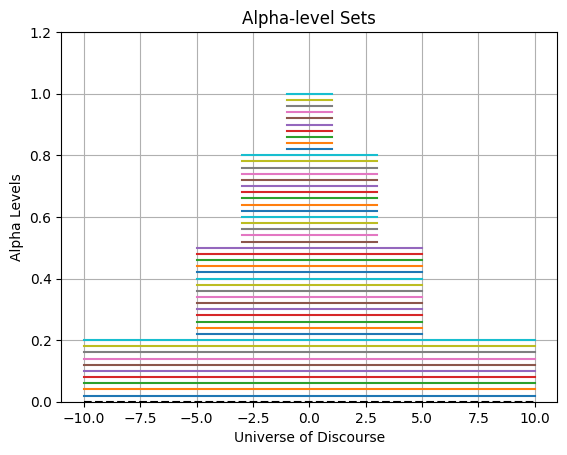

In [ ]:
afs1.visualize()

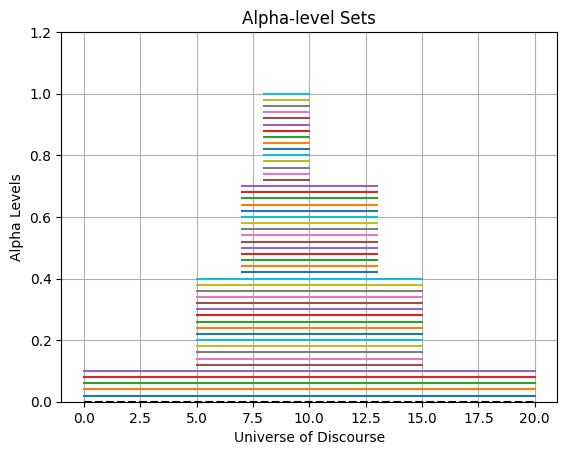

In [ ]:
afs2.visualize()

### Minimum

Minimum: 

Alpha = 0.0: [[-10.0, 20.0]]
Alpha = 0.02: [[0.0, 10.0]]
Alpha = 0.04: [[0.0, 10.0]]
Alpha = 0.06: [[0.0, 10.0]]
Alpha = 0.08: [[0.0, 10.0]]
Alpha = 0.1: [[0.0, 10.0]]
Alpha = 0.12: [[5.0, 10.0]]
Alpha = 0.14: [[5.0, 10.0]]
Alpha = 0.16: [[5.0, 10.0]]
Alpha = 0.18: [[5.0, 10.0]]
Alpha = 0.2: [[5.0, 10.0]]
Alpha = 0.22: []
Alpha = 0.24: []
Alpha = 0.26: []
Alpha = 0.28: []
Alpha = 0.3: []
Alpha = 0.32: []
Alpha = 0.34: []
Alpha = 0.36: []
Alpha = 0.38: []
Alpha = 0.4: []
Alpha = 0.42: []
Alpha = 0.44: []
Alpha = 0.46: []
Alpha = 0.48: []
Alpha = 0.5: []
Alpha = 0.52: []
Alpha = 0.54: []
Alpha = 0.56: []
Alpha = 0.58: []
Alpha = 0.6: []
Alpha = 0.62: []
Alpha = 0.64: []
Alpha = 0.66: []
Alpha = 0.68: []
Alpha = 0.7: []
Alpha = 0.72: []
Alpha = 0.74: []
Alpha = 0.76: []
Alpha = 0.78: []
Alpha = 0.8: []
Alpha = 0.82: []
Alpha = 0.84: []
Alpha = 0.86: []
Alpha = 0.88: []
Alpha = 0.9: []
Alpha = 0.92: []
Alpha = 0.94: []
Alpha = 0.96: []
Alpha = 0.98: []
Alpha = 1.0: []



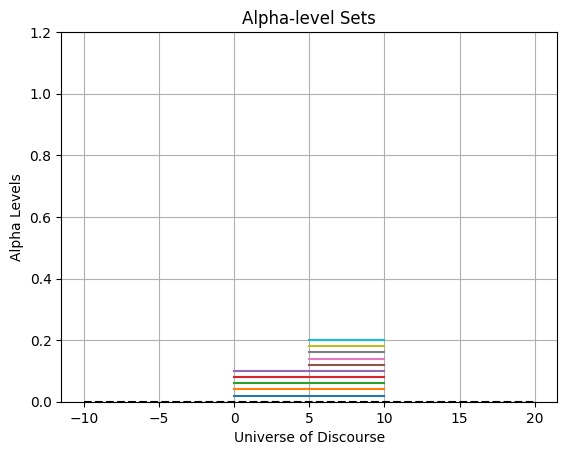

In [ ]:
afs = AlphaFuzzyCombination(afs1, afs2, minimum)

print("Minimum: \n")
for alpha in afs.collection:
  print(f"Alpha = {alpha}: {afs.__getitem__(alpha)}")
print()
afs.visualize()

### Maximum

Maximum: 

Alpha = 0.0: [[-10.0, 20.0]]
Alpha = 0.02: [[-10.0, 20.0]]
Alpha = 0.04: [[-10.0, 20.0]]
Alpha = 0.06: [[-10.0, 20.0]]
Alpha = 0.08: [[-10.0, 20.0]]
Alpha = 0.1: [[-10.0, 20.0]]
Alpha = 0.12: [[-10.0, 15.0]]
Alpha = 0.14: [[-10.0, 15.0]]
Alpha = 0.16: [[-10.0, 15.0]]
Alpha = 0.18: [[-10.0, 15.0]]
Alpha = 0.2: [[-10.0, 15.0]]
Alpha = 0.22: [[-5.0, 15.0]]
Alpha = 0.24: [[-5.0, 15.0]]
Alpha = 0.26: [[-5.0, 15.0]]
Alpha = 0.28: [[-5.0, 15.0]]
Alpha = 0.3: [[-5.0, 15.0]]
Alpha = 0.32: [[-5.0, 15.0]]
Alpha = 0.34: [[-5.0, 15.0]]
Alpha = 0.36: [[-5.0, 15.0]]
Alpha = 0.38: [[-5.0, 15.0]]
Alpha = 0.4: [[-5.0, 15.0]]
Alpha = 0.42: [[-5.0, 5.0], [7.0, 13.0]]
Alpha = 0.44: [[-5.0, 5.0], [7.0, 13.0]]
Alpha = 0.46: [[-5.0, 5.0], [7.0, 13.0]]
Alpha = 0.48: [[-5.0, 5.0], [7.0, 13.0]]
Alpha = 0.5: [[-5.0, 5.0], [7.0, 13.0]]
Alpha = 0.52: [[-3.0, 3.0], [7.0, 13.0]]
Alpha = 0.54: [[-3.0, 3.0], [7.0, 13.0]]
Alpha = 0.56: [[-3.0, 3.0], [7.0, 13.0]]
Alpha = 0.58: [[-3.0, 3.0], [7.0, 13.0]]
Alpha 

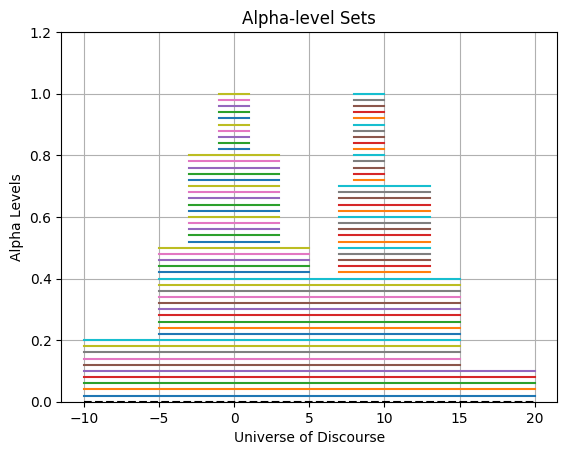

In [ ]:
afs = AlphaFuzzyCombination(afs1, afs2, maximum)

print("Maximum: \n")
for alpha in afs.collection:
  print(f"Alpha = {alpha}: {afs.__getitem__(alpha)}")
print()
afs.visualize()

### Product

Product: 

Alpha = 0.0: [[-10.0, 20.0]]
Alpha = 0.02: [[0.0, 10.0]]
Alpha = 0.04: [[0.0, 10.0]]
Alpha = 0.06: [[0.0, 3.0], [5.0, 10.0]]
Alpha = 0.08: [[0.0, 3.0], [5.0, 10.0]]
Alpha = 0.1: [[0.0, 1.0], [7.0, 10.0]]
Alpha = 0.12: [[7.0, 10.0]]
Alpha = 0.14: [[8.0, 10.0]]
Alpha = 0.16: [[8.0, 10.0]]
Alpha = 0.18: [[8.0, 10.0]]
Alpha = 0.2: [[8.0, 10.0]]
Alpha = 0.22: []
Alpha = 0.24: []
Alpha = 0.26: []
Alpha = 0.28: []
Alpha = 0.3: []
Alpha = 0.32: []
Alpha = 0.34: []
Alpha = 0.36: []
Alpha = 0.38: []
Alpha = 0.4: []
Alpha = 0.42: []
Alpha = 0.44: []
Alpha = 0.46: []
Alpha = 0.48: []
Alpha = 0.5: []
Alpha = 0.52: []
Alpha = 0.54: []
Alpha = 0.56: []
Alpha = 0.58: []
Alpha = 0.6: []
Alpha = 0.62: []
Alpha = 0.64: []
Alpha = 0.66: []
Alpha = 0.68: []
Alpha = 0.7: []
Alpha = 0.72: []
Alpha = 0.74: []
Alpha = 0.76: []
Alpha = 0.78: []
Alpha = 0.8: []
Alpha = 0.82: []
Alpha = 0.84: []
Alpha = 0.86: []
Alpha = 0.88: []
Alpha = 0.9: []
Alpha = 0.92: []
Alpha = 0.94: []
Alpha = 0.96: []
Alpha =

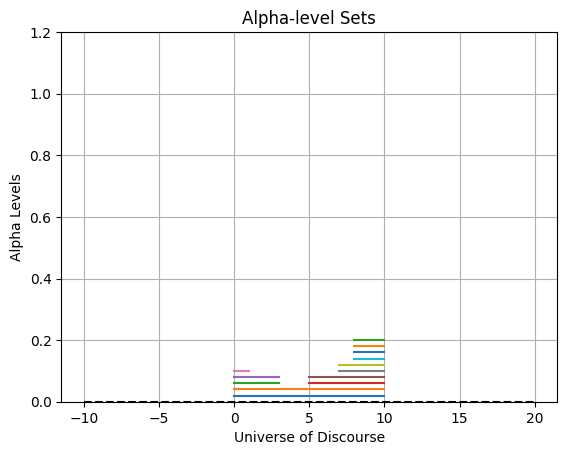

In [ ]:
afs = AlphaFuzzyCombination(afs1, afs2, product)

print("Product: \n")
for alpha in afs.collection:
  print(f"Alpha = {alpha}: {afs.__getitem__(alpha)}")
print()
afs.visualize()

### Bounded Sum

In [ ]:
afs = AlphaFuzzyCombination(afs1, afs2, boundedsum)

print("Bounded Sum: \n")
for alpha in afs.collection:
    print(f"Alpha = {alpha}: {afs.__getitem__(alpha)}")
print()
afs.visualize()

Bounded Sum: 

Alpha = 0.0: [[-10.0, 20.0]]
Alpha = 0.02: [[-10.0, 20.0]]
Alpha = 0.04: [[-10.0, 20.0]]
Alpha = 0.06: [[-10.0, 20.0]]
Alpha = 0.08: [[-10.0, 20.0]]
Alpha = 0.1: [[-10.0, 20.0]]
Alpha = 0.12: [[-10.0, 15.0]]
Alpha = 0.14: [[-10.0, 15.0]]
Alpha = 0.16: [[-10.0, 15.0]]
Alpha = 0.18: [[-10.0, 15.0]]
Alpha = 0.2: [[-10.0, 15.0]]
Alpha = 0.22: [[-5.0, 15.0]]
Alpha = 0.24: [[-5.0, 15.0]]
Alpha = 0.26: [[-5.0, 15.0]]
Alpha = 0.28: [[-5.0, 15.0]]
Alpha = 0.3: [[-5.0, 15.0]]
Alpha = 0.32: [[-5.0, 15.0]]
Alpha = 0.34: [[-5.0, 15.0]]
Alpha = 0.36: [[-5.0, 15.0]]
Alpha = 0.38: [[-5.0, 15.0]]
Alpha = 0.4: [[-5.0, 15.0]]
Alpha = 0.42: [[-5.0, 13.0]]
Alpha = 0.44: [[-5.0, 13.0]]
Alpha = 0.46: [[-5.0, 13.0]]
Alpha = 0.48: [[-5.0, 13.0]]
Alpha = 0.5: [[-5.0, 13.0]]
Alpha = 0.52: [[-3.0, 13.0]]
Alpha = 0.54: [[-3.0, 13.0]]
Alpha = 0.56: [[-3.0, 13.0]]
Alpha = 0.58: [[-3.0, 13.0]]
Alpha = 0.6: [[-3.0, 13.0]]
Alpha = 0.62: [[-3.0, 3.0], [7.0, 13.0]]
Alpha = 0.64: [[-3.0, 3.0], [7.0, 13.0]]


<a name='task5'></a>
## 5. Further

### Compatibility with SoftPy library

Our class is fully compatible with all the operations seen in the SoftPy library, here we see some examples.

Probabilistic Sum: 

Alpha = 0.0: [[-10.0, 20.0]]
Alpha = 0.02: [[-10.0, 20.0]]
Alpha = 0.04: [[-10.0, 20.0]]
Alpha = 0.06: [[-10.0, 20.0]]
Alpha = 0.08: [[-10.0, 20.0]]
Alpha = 0.1: [[-10.0, 15.0]]
Alpha = 0.12: [[-10.0, 15.0]]
Alpha = 0.14: [[-10.0, 15.0]]
Alpha = 0.16: [[-10.0, 15.0]]
Alpha = 0.18: [[-10.0, 15.0]]
Alpha = 0.2: [[-5.0, 15.0]]
Alpha = 0.22: [[-5.0, 15.0]]
Alpha = 0.24: [[-5.0, 15.0]]
Alpha = 0.26: [[-5.0, 15.0]]
Alpha = 0.28: [[-5.0, 15.0]]
Alpha = 0.3: [[-5.0, 15.0]]
Alpha = 0.32: [[-5.0, 15.0]]
Alpha = 0.34: [[-5.0, 15.0]]
Alpha = 0.36: [[-5.0, 15.0]]
Alpha = 0.38: [[-5.0, 15.0]]
Alpha = 0.4: [[-5.0, 15.0]]
Alpha = 0.42: [[-5.0, 13.0]]
Alpha = 0.44: [[-5.0, 13.0]]
Alpha = 0.46: [[-5.0, 13.0]]
Alpha = 0.48: [[-5.0, 13.0]]
Alpha = 0.5: [[-5.0, 13.0]]
Alpha = 0.52: [[-3.0, 13.0]]
Alpha = 0.54: [[-3.0, 5.0], [7.0, 13.0]]
Alpha = 0.56: [[-3.0, 3.0], [7.0, 13.0]]
Alpha = 0.58: [[-3.0, 3.0], [7.0, 13.0]]
Alpha = 0.6: [[-3.0, 3.0], [7.0, 13.0]]
Alpha = 0.62: [[-3.0, 3.0], [

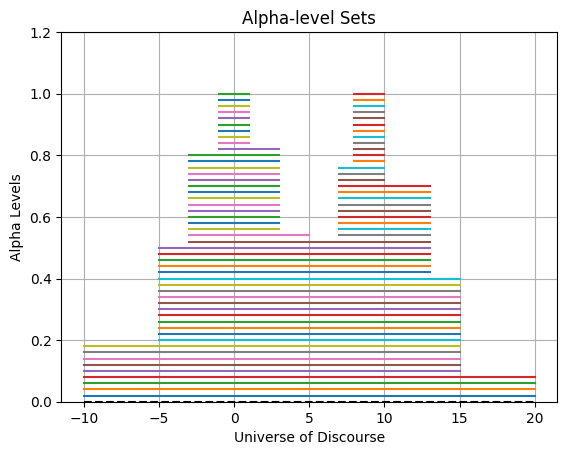

In [ ]:
afs = AlphaFuzzyCombination(afs1, afs2, probsum)

print("Probabilistic Sum: \n")
for alpha in afs.collection:
  print(f"Alpha = {alpha}: {afs.__getitem__(alpha)}")
print()
afs.visualize()

Lukasiewicz T-norm: 

Alpha = 0.0: [[-10.0, 20.0]]
Alpha = 0.02: [[0.0, 1.0], [8.0, 10.0]]
Alpha = 0.04: [[0.0, 1.0], [8.0, 10.0]]
Alpha = 0.06: [[0.0, 1.0], [8.0, 10.0]]
Alpha = 0.08: [[0.0, 1.0], [8.0, 10.0]]
Alpha = 0.1: [[0.0, 1.0], [8.0, 10.0]]
Alpha = 0.12: [[8.0, 10.0]]
Alpha = 0.14: [[8.0, 10.0]]
Alpha = 0.16: [[8.0, 10.0]]
Alpha = 0.18: [[8.0, 10.0]]
Alpha = 0.2: []
Alpha = 0.22: []
Alpha = 0.24: []
Alpha = 0.26: []
Alpha = 0.28: []
Alpha = 0.3: []
Alpha = 0.32: []
Alpha = 0.34: []
Alpha = 0.36: []
Alpha = 0.38: []
Alpha = 0.4: []
Alpha = 0.42: []
Alpha = 0.44: []
Alpha = 0.46: []
Alpha = 0.48: []
Alpha = 0.5: []
Alpha = 0.52: []
Alpha = 0.54: []
Alpha = 0.56: []
Alpha = 0.58: []
Alpha = 0.6: []
Alpha = 0.62: []
Alpha = 0.64: []
Alpha = 0.66: []
Alpha = 0.68: []
Alpha = 0.7: []
Alpha = 0.72: []
Alpha = 0.74: []
Alpha = 0.76: []
Alpha = 0.78: []
Alpha = 0.8: []
Alpha = 0.82: []
Alpha = 0.84: []
Alpha = 0.86: []
Alpha = 0.88: []
Alpha = 0.9: []
Alpha = 0.92: []
Alpha = 0.94: []


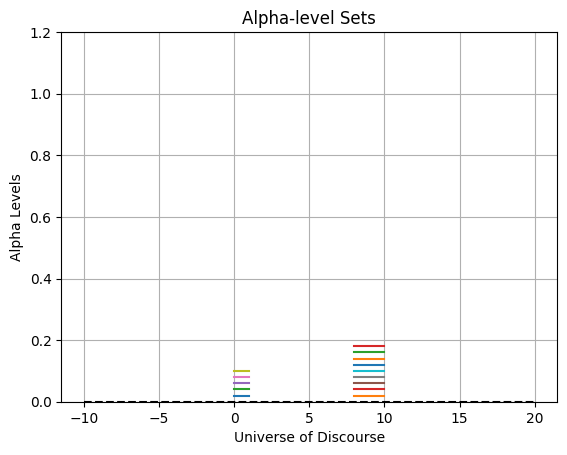

In [ ]:
afs = AlphaFuzzyCombination(afs1, afs2, lukasiewicz)

print("Lukasiewicz T-norm: \n")
for alpha in afs.collection:
  print(f"Alpha = {alpha}: {afs.__getitem__(alpha)}")
print()
afs.visualize()

### Compatibility with the Vertical Representation

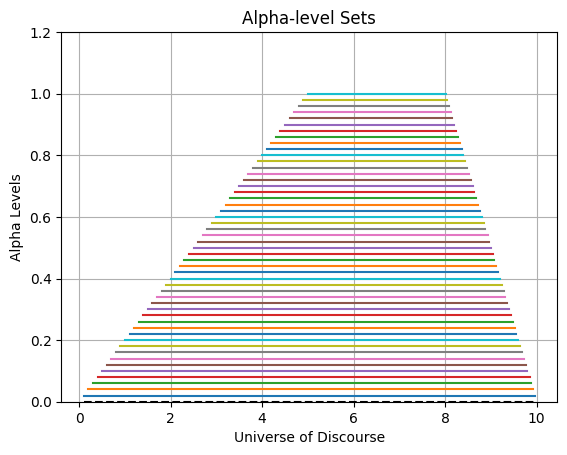

In [ ]:
trap = TrapezoidalFuzzyNumber(0, 5, 8, 10)

alpha_trap = AlphaFuzzySet(collection = None, cont_set = trap)
alpha_trap.visualize()

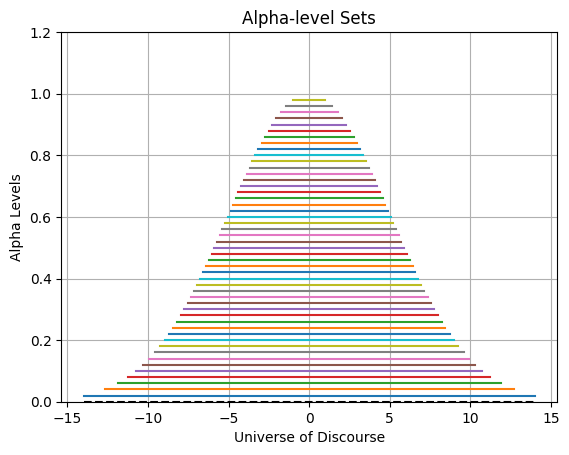

In [ ]:
gauss = GaussianFuzzyNumber(0, 5)

alpha_gauss = AlphaFuzzySet(collection = None, cont_set = gauss)
alpha_gauss.visualize()

Godel Implication: 

Alpha = 0.0: [[-18.6, 19.0]]
Alpha = 0.02: [[0.1, 9.96]]
Alpha = 0.04: [[0.2, 9.92]]
Alpha = 0.06: [[0.3, 9.88]]
Alpha = 0.08: [[0.4, 9.84]]
Alpha = 0.1: [[0.5, 9.8]]
Alpha = 0.12: [[0.6, 9.76]]
Alpha = 0.14: [[0.7, 9.72]]
Alpha = 0.16: [[0.8, 9.58]]
Alpha = 0.18: [[0.9, 9.26]]
Alpha = 0.2: [[1.0, 8.98]]
Alpha = 0.22: [[1.1, 8.71]]
Alpha = 0.24: [[1.2, 8.45]]
Alpha = 0.26: [[1.3, 8.21]]
Alpha = 0.28: [[1.4, 7.98]]
Alpha = 0.3: [[1.5, 7.76]]
Alpha = 0.32: [[1.6, 7.55]]
Alpha = 0.34: [[1.7, 7.35]]
Alpha = 0.36: [[1.8, 7.15]]
Alpha = 0.38: [[1.9, 6.96]]
Alpha = 0.4: [[2.0, 6.77]]
Alpha = 0.42: [[2.1, 6.59]]
Alpha = 0.44: [[2.2, 6.41]]
Alpha = 0.46: [[2.3, 6.24]]
Alpha = 0.48: [[2.4, 6.06]]
Alpha = 0.5: [[2.5, 5.89]]
Alpha = 0.52: [[2.6, 5.72]]
Alpha = 0.54: [[2.7, 5.56]]
Alpha = 0.56: [[2.8, 5.39]]
Alpha = 0.58: [[2.9, 5.22]]
Alpha = 0.6: [[3.0, 5.06]]
Alpha = 0.62: [[3.1, 4.89]]
Alpha = 0.64: [[3.2, 4.73]]
Alpha = 0.66: [[3.3, 4.56]]
Alpha = 0.68: [[3.4, 4.4]]
Alpha 

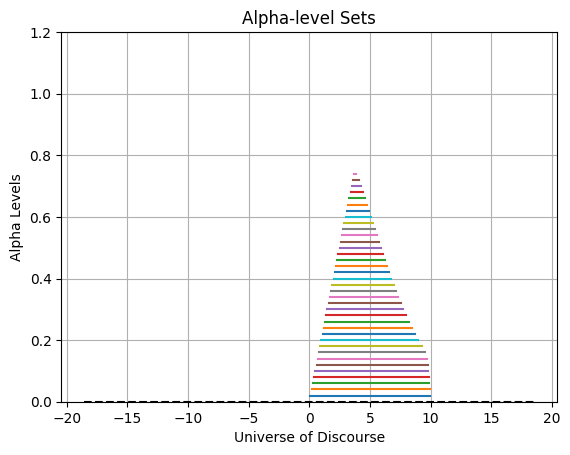

In [ ]:
afs = AlphaFuzzyCombination(gauss, trap, minimum)
print("Godel Implication: \n")
for alpha in afs.collection:
  print(f"Alpha = {alpha}: {afs.__getitem__(alpha)}")
print()
afs.visualize()

### More operations

Godel Implication: 

Alpha = 0.0: [[-10.0, 20.0]]
Alpha = 0.02: [[0.0, 20.0]]
Alpha = 0.04: [[0.0, 20.0]]
Alpha = 0.06: [[0.0, 20.0]]
Alpha = 0.08: [[0.0, 20.0]]
Alpha = 0.1: [[0.0, 20.0]]
Alpha = 0.12: [[5.0, 20.0]]
Alpha = 0.14: [[5.0, 20.0]]
Alpha = 0.16: [[5.0, 20.0]]
Alpha = 0.18: [[5.0, 20.0]]
Alpha = 0.2: [[5.0, 20.0]]
Alpha = 0.22: [[5.0, 20.0]]
Alpha = 0.24: [[5.0, 20.0]]
Alpha = 0.26: [[5.0, 20.0]]
Alpha = 0.28: [[5.0, 20.0]]
Alpha = 0.3: [[5.0, 20.0]]
Alpha = 0.32: [[5.0, 20.0]]
Alpha = 0.34: [[5.0, 20.0]]
Alpha = 0.36: [[5.0, 20.0]]
Alpha = 0.38: [[5.0, 20.0]]
Alpha = 0.4: [[5.0, 20.0]]
Alpha = 0.42: [[5.0, 20.0]]
Alpha = 0.44: [[5.0, 20.0]]
Alpha = 0.46: [[5.0, 20.0]]
Alpha = 0.48: [[5.0, 20.0]]
Alpha = 0.5: [[5.0, 20.0]]
Alpha = 0.52: [[5.0, 20.0]]
Alpha = 0.54: [[5.0, 20.0]]
Alpha = 0.56: [[5.0, 20.0]]
Alpha = 0.58: [[5.0, 20.0]]
Alpha = 0.6: [[5.0, 20.0]]
Alpha = 0.62: [[5.0, 20.0]]
Alpha = 0.64: [[5.0, 20.0]]
Alpha = 0.66: [[5.0, 20.0]]
Alpha = 0.68: [[5.0, 20.0]]
Alph

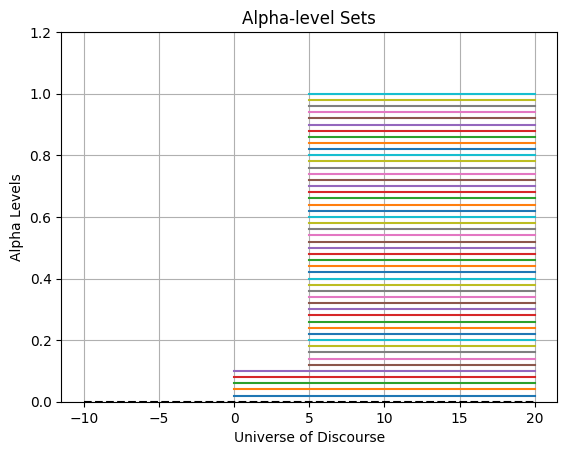

In [ ]:
def godel_implication(a: FuzzySet, b: FuzzySet):
    op = lambda x, y: np.where(x <= y, 1, y)
    if isinstance(a, DiscreteFuzzySet) and isinstance(b, DiscreteFuzzySet):
        return DiscreteFuzzyCombination(a, b, op=op)
    elif isinstance(a, ContinuousFuzzySet) and isinstance(b, ContinuousFuzzySet):
        return ContinuousFuzzyCombination(a, b, op=op)
    else:
        return FuzzyCombination(a, b, op=op)

afs = AlphaFuzzyCombination(afs1, afs2, godel_implication)
print("Godel Implication: \n")
for alpha in afs.collection:
  print(f"Alpha = {alpha}: {afs.__getitem__(alpha)}")
print()
afs.visualize()


In [ ]:
def lukasiewicz_implication(a: FuzzySet, b: FuzzySet):
    op = lambda x, y: np.minimum(1, 1 - x + y)
    if isinstance(a, DiscreteFuzzySet) and isinstance(b, DiscreteFuzzySet):
        return DiscreteFuzzyCombination(a, b, op=op)
    elif isinstance(a, ContinuousFuzzySet) and isinstance(b, ContinuousFuzzySet):
        return ContinuousFuzzyCombination(a, b, op=op)
    else:
        return FuzzyCombination(a, b, op=op)

afs = AlphaFuzzyCombination(afs1, afs2, lukasiewicz_implication)
print("Lukasiewicz Implication: \n")
for alpha in afs.collection:
  print(f"Alpha = {alpha}: {afs.__getitem__(alpha)}")
print()
afs.visualize()

Lukasiewicz Implication: 

Alpha = 0.0: [[-10.0, 20.0]]
Alpha = 0.02: [[-10.0, -1.0], [0.0, 20.0]]
Alpha = 0.04: [[-10.0, -1.0], [0.0, 20.0]]
Alpha = 0.06: [[-10.0, -1.0], [0.0, 20.0]]
Alpha = 0.08: [[-10.0, -1.0], [0.0, 20.0]]
Alpha = 0.1: [[-10.0, -1.0], [0.0, 20.0]]
Alpha = 0.12: [[-10.0, -1.0], [1.0, 20.0]]
Alpha = 0.14: [[-10.0, -1.0], [1.0, 20.0]]
Alpha = 0.16: [[-10.0, -1.0], [1.0, 20.0]]
Alpha = 0.18: [[-10.0, -1.0], [1.0, 20.0]]
Alpha = 0.2: [[-10.0, -3.0], [1.0, 20.0]]
Alpha = 0.22: [[-10.0, -3.0], [1.0, 20.0]]
Alpha = 0.24: [[-10.0, -3.0], [1.0, 20.0]]
Alpha = 0.26: [[-10.0, -3.0], [1.0, 20.0]]
Alpha = 0.28: [[-10.0, -3.0], [1.0, 20.0]]
Alpha = 0.3: [[-10.0, -3.0], [3.0, 20.0]]
Alpha = 0.32: [[-10.0, -3.0], [3.0, 20.0]]
Alpha = 0.34: [[-10.0, -3.0], [3.0, 20.0]]
Alpha = 0.36: [[-10.0, -3.0], [3.0, 20.0]]
Alpha = 0.38: [[-10.0, -3.0], [3.0, 20.0]]
Alpha = 0.4: [[-10.0, -3.0], [3.0, 20.0]]
Alpha = 0.42: [[-10.0, -3.0], [3.0, 20.0]]
Alpha = 0.44: [[-10.0, -3.0], [3.0, 20.0]]
Al